In [1]:
# importing os module 
import os
#import the pandas library and aliasing as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [28]:
# This functions as whether the user wants to save data. It uses recursion to force the user to give a valid answer
def yesno(question):
    """Simple Yes/No Function."""
    prompt = f'{question} ? (y/n): '
    ans = input(prompt).strip().lower()
    if ans not in ['y', 'n']:
        print(f'{ans} is invalid, please try again...')
        return yesno(question)
    if ans == 'y':
        return True
    return False

In [29]:
# This function generates the rmsdpp, rmsdpe, and energy data for plotting
def GenerateData(fname, path):
    rmsdpp_file = open(path + '/rmsdpp.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPP' in line:
                rmsdpp_file.write(str(line.split()[-1]) + '\n')
    rmsdpp_file.close()


    rmsdpe_file = open(path + '/rmsdpe.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if 'RMSDPE' in line:
                rmsdpe_file.write(str(line.split()[-1]) + '\n')
    rmsdpe_file.close()


    energy_file = open(path + '/energy.dat', "x")
    with open(fname, 'r') as f:
        for line in f.readlines():
            if ('smt' in fname):
                if ('The Energy for This Iteration is:' in line):
                    energy_file.write(str(line.split()[6]) + '\n')
            else:
                if 'SubSCF Loop, Total Energy = ' in line:
                    energy_file.write(str(line.split()[7]) + '\n')
    energy_file.close()

In [30]:
# This function reads the log file, extract key information and puts it in the dataframe
def fillDF(log_file,df):
    temp = log_file[:-4].split('_')

    index = log_file[:-4].replace('_smt','').replace('_stw','')

    Alg = temp[1]

    # if the algorithm is simultaneous, we fill in the structure, basis information, and # of smt iterations
    if (Alg == 'smt'):
        df.loc[index]['Structure'] = temp[0]
        df.loc[index]['EBasis'] = temp[2]
        df.loc[index]['PBasis'] = temp[3]

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NBasis=' in line:     
                    df.loc[index]['NEBasis'] = int(line.split()[1])
                    break

        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO NBasis=' in line:     
                    df.loc[index]['NPBasis'] = int(line.split()[2])
                    break

        E_SMT = 0.00
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'NEO-SCF Converged After Iteration #' in line:     
                    df.loc[index]['NSMT'] = int(line.split()[5])
                if ('The Energy for This Iteration is:' in line):
                    E_SMT = float(line.split()[6])
        df.loc[index]['E-SMT'] =  E_SMT        
                    
                    
    # if the algorithm is stepwise, we fill in the # of sub-scf iterations
    if (Alg == 'stw'):

        Elec_Iter = 0
        Prot_Iter = 0
        E_STW = 0.00
        
        with open(log_file, 'r') as f:
            for line in f.readlines():
                if 'Electronic Converged after Iteration #' in line:     
                    Elec_Iter += int(line.split()[5])
                if 'Protonic Converged after Iteration #' in line:     
                    Prot_Iter += int(line.split()[5])
                if ('SubSCF Loop, Total Energy = ' in line):
                    E_STW = float(line.split()[7])

        df.loc[index]['NSTW-E'] = Elec_Iter
        df.loc[index]['NSTW-P'] = Prot_Iter
        df.loc[index]['E-STW'] =  E_STW       

In [31]:
# This function calculates the theoretical computational cost based on # of fock builds and basis size
def getCompCost(NEFock,NPFock,NEBasis,NPBasis):
    return NEFock*np.power(NEBasis,4) + NPFock*np.power(NPBasis,4) + (NEFock+NPFock)*np.power(NEBasis,2)*np.power(NPBasis,2)

In [34]:
# Main code starts here
cwd = os.getcwd()

log_files = []

for file in os.listdir(cwd):
    filename = os.fsdecode(file)
    if filename.endswith(".log"):
        full_name = os.path.join(cwd, filename)
        name_without_path = full_name.split("/")[-1] 
        print(name_without_path)
        log_files.insert(0,str(name_without_path))

hcn_smt_ccpvdz_pb4f1.log
hcn_stw_ccpvtz_pb4d.log
hcn_smt_ccpvdz_pb4f2.log
hcn_smt_ccpvtz_pb4d.log
hcn_stw_ccpvtz_pb4f2.log
hcn_stw_ccpvtz_pb4f1.log
hcn_stw_ccpvqz_pb4f1.log
hcn_stw_ccpvqz_pb4f2.log
hcn_stw_ccpvdz_pb4f1.log
hcn_stw_ccpvdz_pb4f2.log
hcn_stw_ccpvdz_pb4d.log
hcn_smt_ccpvtz_pb4f2.log
hcn_stw_ccpvqz_pb4d.log
hcn_smt_ccpvqz_pb4d.log
hcn_smt_ccpvtz_pb4f1.log
hcn_smt_ccpvdz_pb4d.log
hcn_smt_ccpvqz_pb4f1.log
hcn_smt_ccpvqz_pb4f2.log


In [35]:
saveData = yesno("Do you want to save the data")
print(f'you answer was: {saveData}')

Do you want to save the data ? (y/n): n
you answer was: False


In [36]:
if (saveData):
    for log_file in log_files:
        destination_dir = log_file[:-4]
        all_data_storage_dir = '/Users/aodongliu/LiGroup/gaussian/test_py_data_processing/Data'
        path = os.path.join(all_data_storage_dir, destination_dir)
        os.mkdir(path)
        GenerateData(log_file,path)

In [37]:
structure = 'hcn'
elec_basis_pool = ['cc-pvdz','cc-pvtz','cc-pvqz']
prot_basis_pool = ['pb4d','pb4f1','pb4f2']

In [38]:
Calculations = []
for prot_basis in prot_basis_pool:                                          
    for elec_basis in elec_basis_pool: 
        elec_basis = elec_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
        prot_basis = prot_basis.replace('-', '').replace('(', '').replace(')', '').replace(',', '')
        temp = structure + '_' + elec_basis + '_' + prot_basis
        Calculations.append(temp)

In [40]:
df = pd.DataFrame(columns=['Structure',
                          'EBasis',
                          'PBasis',
                          'NEBasis',
                          'NPBasis',
                          'NSMT',
                          'NSTW-E',
                          'NSTW-P',
                          'E-SMT',
                          'E-STW',
                           'E-Diff',
                           'Basis Ratio',
                           'Cost Ratio'
                          ],index= Calculations)
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
hcn_ccpvdz_pb4d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvtz_pb4d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvqz_pb4d,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvdz_pb4f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvtz_pb4f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvqz_pb4f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvdz_pb4f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvtz_pb4f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hcn_ccpvqz_pb4f2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
for log_file in log_files:
    fillDF(log_file,df)
df

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
hcn_ccpvdz_pb4d,hcn,ccpvdz,pb4d,33,23,62,78,225,-92.84,-92.84,NaN,NaN,NaN
hcn_ccpvtz_pb4d,hcn,ccpvtz,pb4d,74,23,76,87,314,-92.87,-92.87,NaN,NaN,NaN
hcn_ccpvqz_pb4d,hcn,ccpvqz,pb4d,140,23,66,95,409,-92.87,-92.87,NaN,NaN,NaN
hcn_ccpvdz_pb4f1,hcn,ccpvdz,pb4f1,33,30,71,78,234,-92.84,-92.84,NaN,NaN,NaN
hcn_ccpvtz_pb4f1,hcn,ccpvtz,pb4f1,74,30,75,87,278,-92.87,-92.87,NaN,NaN,NaN
hcn_ccpvqz_pb4f1,hcn,ccpvqz,pb4f1,140,30,89,95,344,-92.87,-92.87,NaN,NaN,NaN
hcn_ccpvdz_pb4f2,hcn,ccpvdz,pb4f2,33,37,72,78,234,-92.84,-92.84,NaN,NaN,NaN
hcn_ccpvtz_pb4f2,hcn,ccpvtz,pb4f2,74,37,82,87,295,-92.87,-92.87,NaN,NaN,NaN
hcn_ccpvqz_pb4f2,hcn,ccpvqz,pb4f2,140,37,77,95,325,-92.87,-92.87,NaN,NaN,NaN


In [42]:
# Do some post processing to get the energy difference, computational cost, and cost ratio
df['E-Diff'] = df['E-SMT'] - df['E-STW'] 
df['Cost Ratio'] = getCompCost(df['NSMT'],df['NSMT'],df['NEBasis'],df['NPBasis'])  / getCompCost(df['NSTW-E'],df['NSTW-P'],df['NEBasis'],df['NPBasis'])
df['Basis Ratio'] = df['NPBasis'] / df['NEBasis']

# Prints in a pretty manner
df.style.format({'E-Diff': "{:.2E}",'E-STW': "{:.2f}",'E-SMT': "{:.2f}",'Basis Ratio': "{:.2f}",'Cost Ratio': "{:.2f}"})

,Structure,EBasis,PBasis,NEBasis,NPBasis,NSMT,NSTW-E,NSTW-P,E-SMT,E-STW,E-Diff,Basis Ratio,Cost Ratio
hcn_ccpvdz_pb4d,hcn,ccpvdz,pb4d,33,23,62,78,225,-92.84,-92.84,-1.86E-11,0.70,0.49
hcn_ccpvtz_pb4d,hcn,ccpvtz,pb4d,74,23,76,87,314,-92.87,-92.87,-2.80E-11,0.31,0.71
hcn_ccpvqz_pb4d,hcn,ccpvqz,pb4d,140,23,66,95,409,-92.87,-92.87,-3.90E-11,0.16,0.64
hcn_ccpvdz_pb4f1,hcn,ccpvdz,pb4f1,33,30,71,78,234,-92.84,-92.84,-1.89E-11,0.91,0.48
hcn_ccpvtz_pb4f1,hcn,ccpvtz,pb4f1,74,30,75,87,278,-92.87,-92.87,-5.75E-11,0.41,0.66
hcn_ccpvqz_pb4f1,hcn,ccpvqz,pb4f1,140,30,89,95,344,-92.87,-92.87,-6.97E-11,0.21,0.84
hcn_ccpvdz_pb4f2,hcn,ccpvdz,pb4f2,33,37,72,78,234,-92.84,-92.84,-4.46E-11,1.12,0.44
hcn_ccpvtz_pb4f2,hcn,ccpvtz,pb4f2,74,37,82,87,295,-92.87,-92.87,-6.66E-11,0.50,0.64
hcn_ccpvqz_pb4f2,hcn,ccpvqz,pb4f2,140,37,77,95,325,-92.87,-92.87,-8.37E-11,0.26,0.70


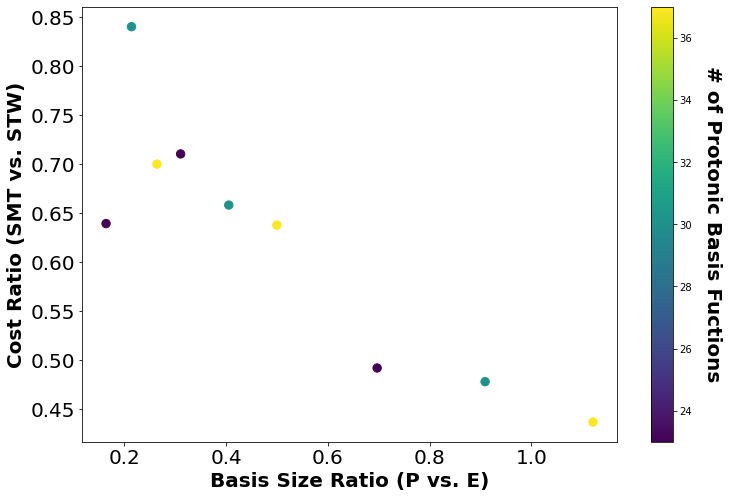

In [56]:
plt.figure(figsize = (12,8))
plt.scatter(df['Basis Ratio'],df['Cost Ratio'],c=df['NPBasis'],s=70)
plt.xlabel('Basis Size Ratio (P vs. E)',size=20,weight='bold')
plt.ylabel('Cost Ratio (SMT vs. STW)',size=20,weight='bold')
plt.xticks(size=20)
plt.yticks(fontsize=20)
cbar = plt.colorbar()
cbar.set_label('# of Protonic Basis Fuctions',size=20, weight='bold', labelpad=30, rotation=270)
plt.savefig('test_hcn.pdf', dpi=600)
plt.show()